# Export RS image

In [59]:
#https://anaconda.org/epihua/scatter_test-copy1/notebook
from IPython.display import Image, display, HTML

%matplotlib inline

from pylab import *

import ee
ee.Initialize()

### 0. test 

In [71]:
region = ee.Geometry.Rectangle([-122.5, 35.0, -122.4, 35.1]);
raw = ee.Image('LANDSAT/LC8_L1T_TOA/LC80440342014077LGN00');
print(raw.getThumbUrl())

https://earthengine.googleapis.com/api/thumb?thumbid=10a9265e64b6572352f23c05de078f34&token=8c0e700dad8f3b1ac89ebdca6c9e4092


In [72]:
Image(url=raw.getThumbUrl())

###  1.SRTM

In [106]:
srtm = ee.Image('USGS/SRTMGL1_003')
DEM_Palette = ','.join(['#028900','#ff0000','#ffc425'])
print(DEM_Palette)

Image(url=srtm.getThumbUrl({
                'min': 0,
                'max': 7000,
                'palette': DEM_Palette}))


#028900,#ff0000,#ffc425


### 2. Landsat

####     2.1 start from ImageCollection

In [184]:
regionfilter = ee.Geometry.Rectangle([135.4, 34.9, 135.5, 35.0])
raw = ee.ImageCollection('LANDSAT/LC8_SR')

#fail to get information (Data, bandnames...)
#https://developers.google.com/earth-engine/image_info
print(raw.toList(10).getInfo()['features'])

TypeError: list indices must be integers, not str

In [167]:
#image = ee.Algorithms.Landsat.simpleComposite({
#  collection:ee.ImageCollection('LANDSAT/LC8_L1T'),
#  asFloat:true,
#}).select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7')

In [168]:
##filter Date and Region
raw201601 = raw.filterDate('2016-01-01', '2016-02-02').filterBounds(regionfilter.toGeoJSON())

##ImageCollection to image
##pick up the first one
raw_image = ee.Image(raw201601.first())

##can I pick up selected information through python?
#print(raw_image.bandNames())
#print(ee.Date(raw_image.get('system:time_start')))
#print(raw_image.getInfo())


In [195]:
##calculate ndvi
ndvi = (raw_image.select('B5').subtract(raw_image.select('B4'))).divide(raw_image.select('B5').add(raw_image.select('B4')));
print(ndvi.getThumbUrl())

https://earthengine.googleapis.com/api/thumb?thumbid=3d6af91303acb11812361a021637ee7f&token=030352152bee08f9d58a14243fa20078


In [196]:
#Image(url=ndvi.getThumbUrl({'region':region.toGeoJSON()}))
ndvi_palette = 'FFFFFF, CE7E45, DF923D, F1B555, FCD163, 99B718, 74A901, 66A000, 529400, 3E8601, 207401, 056201, 004C00, 023B01, 012E01, 011D01, 011301'
vizParams = {'min': -0.1, 'max': 1, 'palette': ndvi_palette}
Image(url=ndvi.getThumbUrl(vizParams))


define parameter as list

https://developers.google.com/earth-engine/exporting

maxPixels

The maxPixels parameter is intended to prevent very large exports from inadvertently being created. Increase maxPixels if the default value is too low for your intended output image. If the output image file is large, it will be exported as multiple tiles. If the image is split into tiles, the filename of each tile will be in the form baseFilename-yMin-xMin where xMin and yMin are the coordinates of each tile within the overall bounding box of the exported image.

In [197]:
raw_list = raw_image.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=regionfilter,
  maxPixels=5e9);

pick up band values

In [198]:
raw4 = ee.Array(raw_list.get('B4'))
band4 = array(raw4.getInfo())
print(size(band4))

raw5 = ee.Array(raw_list.get('B5'))
band5 = array(raw5.getInfo())
print(size(band5))


112515
112515


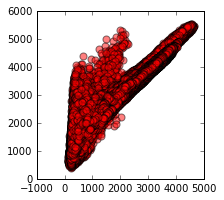

In [199]:
fig1 = figure(figsize=(3,3), dpi=80)
scatter(band4, band5, s=50, c='red', alpha=0.5)


# Export tif to Drive as a test

### original data

#### Compare with original data downloaded from Earth Explorer

In [203]:
#.float() is needed
## check again
## 25 tif files were created...

#raw_float = raw_image.float()
raw_int = raw_image.int16()

task = ee.batch.Export.image(raw_int, 'test_img', {
        'maxPixels':5e9})
task.start()


In [204]:
task.status()

{u'creation_timestamp_ms': 1479910994895,
 u'description': u'test_img',
 u'id': u'TKHR36VJGXQJOAALIMGKC4B7',
 u'progress': 0.0,
 u'start_timestamp_ms': 1479910997620,
 u'state': u'RUNNING',
 u'task_type': u'EXPORT_IMAGE',
 u'update_timestamp_ms': 1479910997792}

In [205]:
import time 
while task.status()['state'] == 'RUNNING':
    print 'Running...'
    time.sleep(100)
print 'Done.', task.status()

Running...
Running...
Running...
Running...
Done. {u'task_type': u'EXPORT_IMAGE', u'description': u'test_img', u'output_url': [u'https://drive.google.com/'], u'update_timestamp_ms': 1479911390840, u'creation_timestamp_ms': 1479910994895, u'state': u'COMPLETED', u'start_timestamp_ms': 1479910997620, u'id': u'TKHR36VJGXQJOAALIMGKC4B7'}


### NDVI data

In [200]:
ndvi_int = ndvi.multiply(10000).int16()
task = ee.batch.Export.image(ndvi_int, 'ndvi_img', {
        'maxPixels':5e9})
task.start()

In [202]:
time.sleep(10)
while task.status()['state'] == 'RUNNING':
    print 'Running...'
    time.sleep(100)
print 'Done.', task.status()

Running...
Done. {u'task_type': u'EXPORT_IMAGE', u'description': u'ndvi_img', u'output_url': [u'https://drive.google.com/'], u'update_timestamp_ms': 1479910655575, u'creation_timestamp_ms': 1479910606801, u'state': u'COMPLETED', u'start_timestamp_ms': 1479910610643, u'id': u'RR5K2ZJZTGBFY3VDXC7K46ZA'}


In [179]:
##see also this code
#https://13975973057543748996.googlegroups.com/attach/2a8c2ddcad1333ad/batch_clip_MODIS-saveAsImages.py?part=0.1&view=1&vt=ANaJVrHr1ij01pneYdSXzJ693-37mvKmyMznjf3vzaT6BTc6DJAScLapG94FU3OrpqxF0WGiBumViTiDdBvlOBfVfzlKNCnF8dL0IWGY9LcY_O3z6T4uoGc


{u'creation_timestamp_ms': 1479908521256,
 u'description': u'ndvi_img',
 u'id': u'RNL56PDQEEVVYA6RG3DZNCDK',
 u'progress': 0.0,
 u'start_timestamp_ms': 1479908524270,
 u'state': u'RUNNING',
 u'task_type': u'EXPORT_IMAGE',
 u'update_timestamp_ms': 1479908524455}